In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Use inline plots
%matplotlib inline
# Enable interactive figures
#%matplotlib nbagg
# on a high-dpi monitor this will increase the quality of plots on-screen
%config InlineBackend.figure_format = 'retina'


In [82]:
# Constants
SIZE_X = 100
SIZE_Y = 100

#ORIGIN_X = np.floor(SIZE_Y/2.0)
#ORIGIN_Y = np.floor(SIZE_Y/2.0)

ORIGIN_X = 1
ORIGIN_Y = 1

SCALE = 0.1 # Value in meter for each pixel

TX_POWER = 0 #dBm
REFERENCE_LOSS_1M = 1 #dBm
PATH_LOSS_EXP = 2

In [83]:
# Calculate distance between coordinates using pythagoras theorem
def distance2d(src_x, src_y, dst_x, dst_y):
    dx = (dst_x-src_x)*SCALE
    dy = (dst_y-src_y)*SCALE
    return np.sqrt((dx**2)+(dy**2))

In [84]:
def heatmap2d(arr: np.ndarray, cmap='hot_r'):
    plt.imshow(arr, cmap=cmap)
    plt.colorbar()
    ax = plt.gca()
    #datacursor(ax)
    plt.show()

In [85]:
def normalize_2d(matrix):
    return (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

In [86]:
def path_loss_one_slope(d, ref_loss=REFERENCE_LOSS_1M, exponent=PATH_LOSS_EXP):
    return (ref_loss + 10*exponent*np.log10(d)) if d > 1 else ref_loss

In [87]:
# Base matrix with unit value
m = np.empty(shape=(SIZE_X,SIZE_Y))
m.fill(1)

In [88]:
# Distance matrix
dm = np.zeros(shape=(SIZE_X,SIZE_Y))

for x,y in np.ndindex(m.shape):
    dm[x,y] = distance2d(ORIGIN_X,ORIGIN_Y,x,y)

In [89]:
# Loss matrix
m_loss = np.zeros(shape=dm.shape)
for x,y in np.ndindex(m_loss.shape):
    m_loss[x,y] = path_loss_one_slope(dm[x,y])

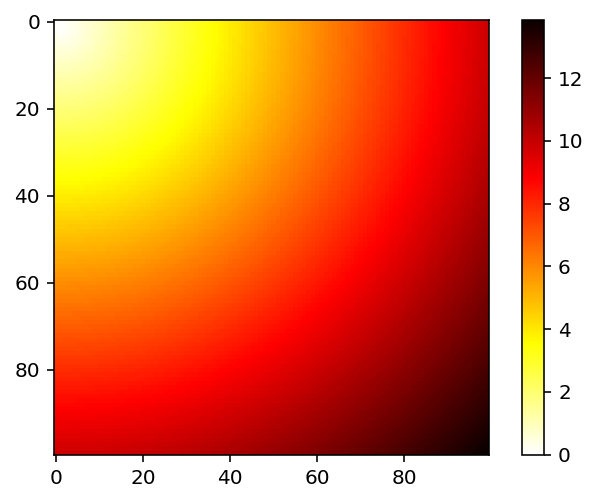

In [90]:
heatmap2d(dm)

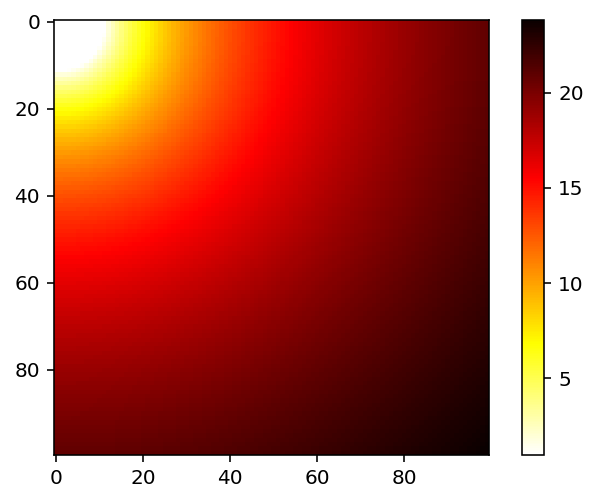

In [91]:
heatmap2d(m_loss)

In [92]:
rssi = TX_POWER - m_loss

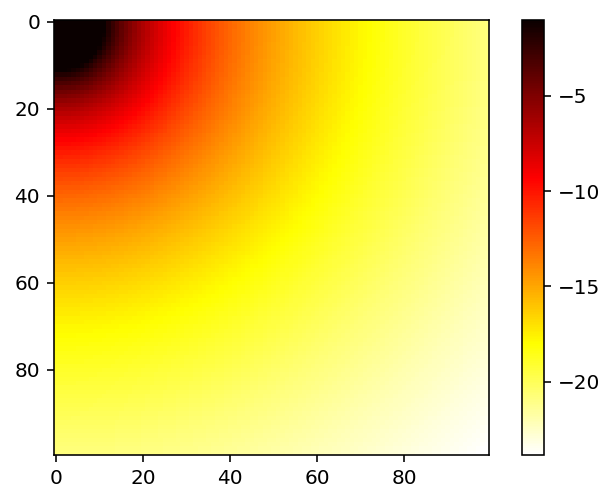

In [93]:
heatmap2d(rssi)